In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json

from scipy import integrate

In [2]:
(10_808 * 1_000_000) / 7 / (5_104_476 + 388_920 + 254_375) * 3

805.8776176016754

In [26]:
system_name = "T3 Technology_5kW_without Fit_10 kWh"
monthly_consumption_kWh = 805.8776176016754
tou = False
month = "July"
year = 2024
fit_price = 2.2

In [27]:
pv_system_folder = "PV Information"

for file in os.listdir(pv_system_folder):
    if system_name in file:
        with open(os.path.join(pv_system_folder, file), "r") as pv_system_info_file:
            pv_system_info = json.load(pv_system_info_file)

full_json = pv_system_info
full_json["FiT price"] = fit_price

In [28]:
consumption_profile_folder = "Daily Consumption Profile"

tariff_consumption_threshold = 150
if tou:
    tariff_type = "1.3"
elif monthly_consumption_kWh <= tariff_consumption_threshold:
    tariff_type = "1.1"
else:
    tariff_type = "1.2"

for file in os.listdir(consumption_profile_folder):
    if tariff_type in file and "Unit" in file:
        consumption_profile_df = pd.read_csv(os.path.join(consumption_profile_folder, file))
        break

consumption_profile_df["Consumption"] = consumption_profile_df["Consumption"] * monthly_consumption_kWh
full_df = consumption_profile_df
full_json["tariff type"] = tariff_type
full_json["monthly consumption"] = monthly_consumption_kWh

In [29]:
generation_profile_folder = "Daily Generation Profile"

for file in os.listdir(generation_profile_folder):
    if "Unit" in file:
        generation_profile_df = pd.read_csv(os.path.join(generation_profile_folder, file))

egat_region = full_json["egat region"]

generation_profile_df["Generation"] = (
    generation_profile_df[egat_region] * full_json["monthly solar energy"]
)
generation_profile_df = generation_profile_df[["time", "Generation"]]

full_df["Generation"] = generation_profile_df["Generation"]

In [30]:
energy_saved_profile_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Energy saved": np.minimum(full_df["Consumption"], full_df["Generation"]),
    }
)
full_df["Energy saved"] = energy_saved_profile_df["Energy saved"]

energy_saved = integrate.trapezoid(
    energy_saved_profile_df["Energy saved"], energy_saved_profile_df["time"]
)
full_json["energy saved"] = energy_saved

In [31]:
battery_profile_arr = []
battery_capacity = full_json["battery"] * 30.4375
if tou:
    on_peak_period = [9, 22]
    for index, values in full_df.iterrows():
        if not on_peak_period[0] <= values["time"] < on_peak_period[1]:
            if index == 0:
                battery_profile_arr.append(battery_capacity)
                continue
            elif battery_profile_arr[-1] < battery_capacity:
                battery_profile_arr.append(battery_capacity)
            else:
                battery_profile_arr.append(battery_profile_arr[-1])
        else:
            if battery_profile_arr[-1] > 0:
                battery_profile_arr.append(max([battery_profile_arr[-1] - max([(values["Generation"] - values["Consumption"]), 0]), 0]))
            else:
                battery_profile_arr.append(battery_profile_arr[-1])
else:
    for index, values in full_df.iterrows():
        if index == 0:
            battery_profile_arr.append(0)
            continue
        if values["Generation"] - values["Consumption"] > 0:
            battery_profile_arr.append(min(battery_profile_arr[-1] + (values["Generation"] - values["Consumption"]), battery_capacity))
        else:
            battery_profile_arr.append(max(battery_profile_arr[-1] - (values["Consumption"] - values["Generation"]), 0))

battery_profile_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Battery": battery_profile_arr,
        "Charging": np.maximum(
            battery_profile_arr
            - np.insert(battery_profile_arr, 0, battery_profile_arr[0])[:-1],
            0,
        ),
        "Discharging": np.minimum(
            battery_profile_arr
            - np.insert(battery_profile_arr, 0, battery_profile_arr[0])[:-1],
            0,
        ),
    }
)

full_df["Battery"] = battery_profile_df["Battery"]
full_df["Charging"] = battery_profile_df["Charging"]
full_df["Discharging"] = battery_profile_df["Discharging"]

energy_charged = integrate.trapezoid(battery_profile_df["Charging"], battery_profile_df["time"])
energy_discharged = integrate.trapezoid(
    battery_profile_df["Discharging"], battery_profile_df["time"]
)

In [32]:
energy_sold_profile_df = pd.DataFrame({"time":full_df["time"]})

if pv_system_info["FiT"]:
    energy_sold_profile_df["Energy sold"] = np.maximum(
        0, (full_df["Generation"] - full_df["Consumption"]).to_numpy()
    )
else:
    energy_sold_profile_df["Energy sold"] = np.zeros(full_df.shape[0])
full_df["Energy sold"] = energy_sold_profile_df["Energy sold"]

energy_sold = integrate.trapezoid(
    energy_sold_profile_df["Energy sold"], energy_sold_profile_df["time"]
)
full_json["Energy sold"] = energy_sold

In [33]:
net_consumption_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Net consumption": full_df["Consumption"]
        # + full_df["Charging"]
        # + full_df["Discharging"]
        - full_df["Energy saved"],
    }
)

Text(0.5, 0, 'Time of Day (hour)')

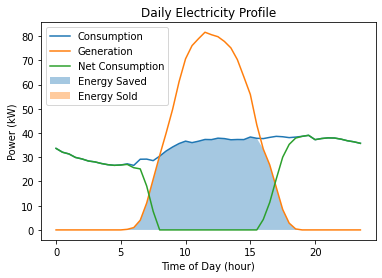

In [34]:
plt.plot(
    consumption_profile_df["time"],
    consumption_profile_df["Consumption"],
    label="Consumption",
)

plt.plot(
    generation_profile_df["time"],
    generation_profile_df["Generation"],
    label="Generation",
)

plt.plot(net_consumption_df["time"], net_consumption_df["Net consumption"], label="Net Consumption")

plt.fill_between(energy_saved_profile_df["time"], energy_saved_profile_df["Energy saved"], alpha=0.4, label="Energy Saved")

plt.fill_between(
    energy_sold_profile_df["time"],
    energy_sold_profile_df["Energy sold"] + consumption_profile_df["Consumption"],
    consumption_profile_df["Consumption"],
    alpha=0.4,
    label="Energy Sold",
)

plt.legend()
plt.title("Daily Electricity Profile")
plt.ylabel("Power (kW)")
plt.xlabel("Time of Day (hour)")

In [35]:
def energy2cost_no_tou(monthly_consumption_kWh):
    cost = 0
    if monthly_consumption_kWh < tariff_consumption_threshold:
        cost += np.max([(np.min([15, monthly_consumption_kWh]) - 0) * 2.3488, 0])
        cost += np.max([(np.min([25, monthly_consumption_kWh]) - 15) * 2.9882, 0])
        cost += np.max([(np.min([35, monthly_consumption_kWh]) - 25) * 3.2405, 0])
        cost += np.max([(np.min([100, monthly_consumption_kWh]) - 35) * 3.6237, 0])
        cost += np.max([(np.min([150, monthly_consumption_kWh]) - 100) * 3.7171, 0])
    else:
        cost += np.max([(np.min([150, monthly_consumption_kWh]) - 0) * 3.2484, 0])
        cost += np.max([(np.min([400, monthly_consumption_kWh]) - 150) * 4.2218, 0])
        cost += np.max([(monthly_consumption_kWh - 400) * 3.2484, 0])
    return cost

In [60]:
# Convert energy saved to money saved
money_saved = 0

if tou:
    pass
else:
    original_price = energy2cost_no_tou(monthly_consumption_kWh)
    new_price = energy2cost_no_tou(
        monthly_consumption_kWh - energy_saved - energy_charged * 2
    )
    money_saved = original_price - new_price

In [53]:
money_sold = 0

if pv_system_info["FiT"]:
    money_sold += energy_sold * 2.2

In [54]:
energy_charged

152.1875

In [55]:
money_saved

1148.648065909557

In [56]:
money_saved

1148.648065909557

In [57]:
total_profit = money_saved + money_sold
total_profit

1148.648065909557

In [58]:
total_profit * 12 * 0.031

427.29708051835524

In [59]:
10 * 30.4375 * (5.7982-2.6369) * 12 * 0.031

357.9460957499999